# BioNeMo - Geneformer inferencing for single cell downstream tasks

This tutorial showcases how to run the BioNeMo container, pre-train a geneformer model, and use it for inferencing downstream single cell tasks. At the end of this tutorial, a user will learn:
- launching the BioNeMo container
- Download data from czi to use for pre-training and inference.
- Convert AnnData files into the sparse SCDL memmap format used by BioNeMo
- Kick-off pretraining with a custom single cell dataset
- Restore the pre-trained model and perform inference with the same czi dataset.


### Prerequisites:
- BioNeMo Framework container is running (refer to the [Getting Started](../index.md) section)


#### Running the BioNeMo container

This example has been built by launching the container in a local machine with 2 x A6000 RTX GPUs. Refer to specific instructions for [remote and multi-node launch]

Once the container is launched, navigate to http://0.0.0.0:8888, http://localhost:8888, or the IP address of the workstation/node. A JupyterLab instance should show up.

#### Copy this code and input files into JupyterLab

In the launched JupyterLab, run the codes in a Jupyter notebook as provided in the code cells below.

## Getting example single cell data and setting it up for inference

First, we must acquire single cell training data for inference. To do this we will install the cellxgene-census api and download a small dataset. We use the example provided by the czi api examples page to download a single h5ad file. Generally, our workflow expects a collection of h5ad files to be used for pre-training. In this case, we restrict to 100k cells from a single dataset  to keep training time and downloading time small.

In [1]:
!pip install cellxgene-census

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/p

In [2]:
# Below are paths required for setting up pre-training and inference.
tutorial_data_dir = "/workspace/bionemo2/data/singlecell_tutorial/download_anndata"
train_tutorial_data_dir = "/workspace/bionemo2/data/singlecell_tutorial/download_anndata/train"
val_tutorial_data_dir = "/workspace/bionemo2/data/singlecell_tutorial/download_anndata/val"
test_tutorial_data_dir = "/workspace/bionemo2/data/singlecell_tutorial/download_anndata/test"

train_tutorial_processed_dir = "/workspace/bionemo2/data/singlecell_tutorial/processed_data/train"
val_tutorial_processed_dir = "/workspace/bionemo2/data/singlecell_tutorial/processed_data/val"
test_tutorial_processed_dir = "/workspace/bionemo2/data/singlecell_tutorial/processed_data/test"
tutorial_output_dir = "/workspace/bionemo2/data/singlecell_tutorial/inference_output"
tutorial_output_inference_pickle = f"{tutorial_output_dir}/human_covid19_bcells_from_scratch.pkl"
demo_data_train_download_path = f"{train_tutorial_data_dir}/human_covid19_bcells.h5ad"
demo_data_val_download_path = f"{val_tutorial_data_dir}/human_covid19_bcells.h5ad"
demo_data_test_download_path = f"{test_tutorial_data_dir}/human_covid19_bcells.h5ad"

In [3]:
!mkdir -p {train_tutorial_data_dir}
!mkdir -p {val_tutorial_data_dir}
!mkdir -p {test_tutorial_data_dir}
!mkdir -p {train_tutorial_processed_dir}
!mkdir -p {val_tutorial_processed_dir}
!mkdir -p {test_tutorial_processed_dir}
!mkdir -p {tutorial_output_dir}

In [4]:
import cellxgene_census


frac_train = 0.8
frac_val = 0.1
frac_test = 0.1

with cellxgene_census.open_soma(census_version="2023-12-15") as census:
    filter1 = (
        "cell_type == 'B cell' and tissue_general == 'lung' and disease == 'COVID-19' and is_primary_data == True"
    )

    adata = cellxgene_census.get_anndata(
        census=census,
        organism="Homo sapiens",
        obs_value_filter=filter1,
    )
    n_train = int(adata.shape[0] * frac_train)
    n_val = int(adata.shape[0] * frac_val)
    n_test = adata.shape[0] - n_train - n_val
    # Create some splits, bad practice since ordering may be a thing but let's just take ranges for this demo.
    adata_train = adata[0:n_train].copy()
    adata_val = adata[n_train : (n_train + n_val)].copy()
    adata_test = adata[(n_train + n_val) :].copy()
    adata_train.write(demo_data_train_download_path)
    adata_val.write(demo_data_val_download_path)
    adata_test.write(demo_data_test_download_path)

/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [5]:
!rm -rf  {train_tutorial_processed_dir}
!rm -rf  {val_tutorial_processed_dir}
!rm -rf  {test_tutorial_processed_dir}

In [6]:
# Create training data processed directory
!convert_h5ad_to_scdl \
  --data-path {train_tutorial_data_dir} \
  --save-path {train_tutorial_processed_dir}

# Create validation data processed directory
!convert_h5ad_to_scdl \
  --data-path {val_tutorial_data_dir} \
  --save-path {val_tutorial_processed_dir}

# Create test data processed directory
!convert_h5ad_to_scdl \
  --data-path {test_tutorial_data_dir} \
  --save-path {test_tutorial_processed_dir}

In [7]:
!ls -laht {train_tutorial_processed_dir}

total 12M
drwxr-xr-x 5 jomitchell domain-users 4.0K Mar 24 21:51 ..
-rw-r--r-- 1 jomitchell domain-users   18 Mar 24 21:51 metadata.json
drwxr-xr-x 2 jomitchell domain-users 4.0K Mar 24 21:51 features
drwxr-xr-x 3 jomitchell domain-users 4.0K Mar 24 21:51 .
-rw-r--r-- 1 jomitchell domain-users 5.9M Mar 24 21:51 col_ptr.npy
-rw-r--r-- 1 jomitchell domain-users  15K Mar 24 21:51 row_ptr.npy
-rw-r--r-- 1 jomitchell domain-users 5.9M Mar 24 21:51 data.npy
-rw-r--r-- 1 jomitchell domain-users    7 Mar 24 21:51 version.json


# Pretraining
Now that we have converted the h5ad files to scdl memmapped files we can begin training. We will kickoff training.

Check the full recipe/config file in `pretrain-recipe-short.yaml` for a complete list of arguments and config parameters.

In [8]:
# See where the processed data is stored
{train_tutorial_processed_dir}

{'/workspace/bionemo2/data/singlecell_tutorial/processed_data/train'}

In [9]:
# Create the recipe file
!bionemo-geneformer-recipe --recipe geneformer_10m_shortpretrain_recipe --dest pretrain-recipe-short.yaml --result-dir /workspace/bionemo2/results --data-path /workspace/bionemo2/data/singlecell_tutorial/processed_data/

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:239: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/triton/layer_norm.py:985: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/triton/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. 

In [10]:
# Run pretraining using the short recipe
!python /workspace/bionemo2/sub-packages/bionemo-geneformer/src/bionemo/geneformer/run/main.py \
--config /workspace/bionemo2/docs/docs/user-guide/examples/bionemo-geneformer/pretrain-recipe-short.yaml

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:239: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/triton/layer_norm.py:985: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/triton/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. 

# Running inference.

We can see from the above training job that the model was trained 1000 steps. At the end of training, the experiment manager leaves a message about where the resulting `.ckpt` checkpoint is written. This file is used for finetuning, inference, or training from an existing set of model weights. See the example produced below from our run:

```text
[NeMo I 2025-03-11 20:32:11 nemo_logging:393] Global Checkpoint Save : Rank: 0 : Iteration: 499 : Start time: 1741725131.041s : Save duration: 0.014s
[NeMo I 2025-03-11 20:32:14 nemo_logging:393] Scheduled async checkpoint save for /workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0.ckpt
[NeMo I 2025-03-11 20:32:14 nemo_logging:393] Global Checkpoint Save : Rank: 0 : Iteration: 499 : Start time: 1741725134.016s : Save duration: 0.013s
[NeMo I 2025-03-11 20:32:16 nemo_logging:393] Scheduled async checkpoint save for /workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0-last.ckpt
[NeMo I 2025-03-11 20:32:17 nemo_logging:393] Successfully saved checkpoint from iteration     499 to /workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0.ckpt
[NeMo I 2025-03-11 20:32:17 nemo_logging:393] Async checkpoint save for step 500 (/workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0.ckpt) finalized successfully.
[NeMo I 2025-03-11 20:32:17 nemo_logging:393] Successfully saved checkpoint from iteration     499 to /workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0-last.ckpt
[NeMo I 2025-03-11 20:32:17 nemo_logging:393] Async checkpoint save for step 500 (/workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0-last.ckpt) finalized successfully.
[NeMo I 2025-03-11 20:32:17 nemo_logging:393] Async finalization time took 0.090 s
```

We will take the most recent `.ckpt` file and use it for inference.

In [11]:
# Instead of hardcoding the checkpoint path, search for the latest checkpoint in the results directory using python.
import glob
import os


# Get all checkpoint files in the results directory
checkpoint_files = glob.glob("/workspace/bionemo2/results/geneformer-10m/dev/checkpoints/**")

# # Sort the checkpoint files by modification time
checkpoint_files.sort(key=lambda x: os.path.getmtime(x))

# # Get the latest checkpoint file
latest_checkpoint = checkpoint_files[-1]
pretrained_checkpoint_path = latest_checkpoint
print(pretrained_checkpoint_path)

/workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.76-step=499-consumed_samples=4000.0-last


In [12]:
!ls -altrh {pretrained_checkpoint_path}

total 16K
drwxr-xr-x  4 jomitchell domain-users 4.0K Mar 24 20:40 .
drwxr-xr-x  2 jomitchell domain-users 4.0K Mar 24 20:40 context
drwxr-xr-x  2 jomitchell domain-users 4.0K Mar 24 20:40 weights
drwxr-xr-x 29 jomitchell domain-users 4.0K Mar 24 20:40 ..


In [13]:
!python /workspace/bionemo2/sub-packages/bionemo-geneformer/src/bionemo/geneformer/scripts/infer_geneformer.py \
    --data-dir {test_tutorial_processed_dir} \
    --checkpoint-path {pretrained_checkpoint_path} \
    --results-path {tutorial_output_dir}

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:239: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/triton/layer_norm.py:985: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/triton/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. 

In [14]:
!ls -altrh {tutorial_output_dir}/
tutorial_output_inference_pickle = f"{tutorial_output_dir}/predictions__rank_0.pt"
!ls -altrh {tutorial_output_inference_pickle}

total 128K
drwxr-xr-x 2 jomitchell domain-users 4.0K Mar 11 20:41 .
drwxr-xr-x 5 jomitchell domain-users 4.0K Mar 12 19:06 ..
-rw-r--r-- 1 jomitchell domain-users 118K Mar 24 21:52 predictions__rank_0.pt
-rw-r--r-- 1 jomitchell domain-users 118K Mar 24 21:52 /workspace/bionemo2/data/singlecell_tutorial/inference_output/predictions__rank_0.pt


# Load inference result and cluster with UMAP.
Now we will inspect our result. First, we expect there to be one prediction for each cell, we can compare the shape of the anndata object to the predictions produced by our model. After this, we can simply pass our embeddings into umap, and view the result! In this case its a very poorly trained model with very few cells, so keep expectations low!

The inference_results .pt file contains one set of hiddens and embeddings for each cell. The hiddens contain the embedding per-token, whereas the embeddings contain the mean embedding for all gene tokens with special tokens (CLS, MASK, etc) removed.

In [15]:
# Load inference results with torch load
import torch


inference_results = torch.load(tutorial_output_inference_pickle)
print(inference_results.keys())

# print(len(inference_results), adata.shape, inference_results[0].keys())
print(inference_results["embeddings"].shape)

dict_keys(['token_logits', 'binary_logits', 'embeddings'])
torch.Size([232, 256])


In [16]:
import umap


reducer = umap.UMAP()
embedding = reducer.fit_transform(inference_results["embeddings"].float())

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
print("embedding.shape: ", embedding.shape)
print("adata_test.obs.shape[0]: ", adata_test.obs.shape[0])
assert adata_test.obs.shape[0] == inference_results["embeddings"].shape[0]

embedding.shape:  (232, 2)
adata_test.obs.shape[0]:  232


/tmp/ipykernel_109164/3584793474.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cov, cov_df in results.groupby(covar):


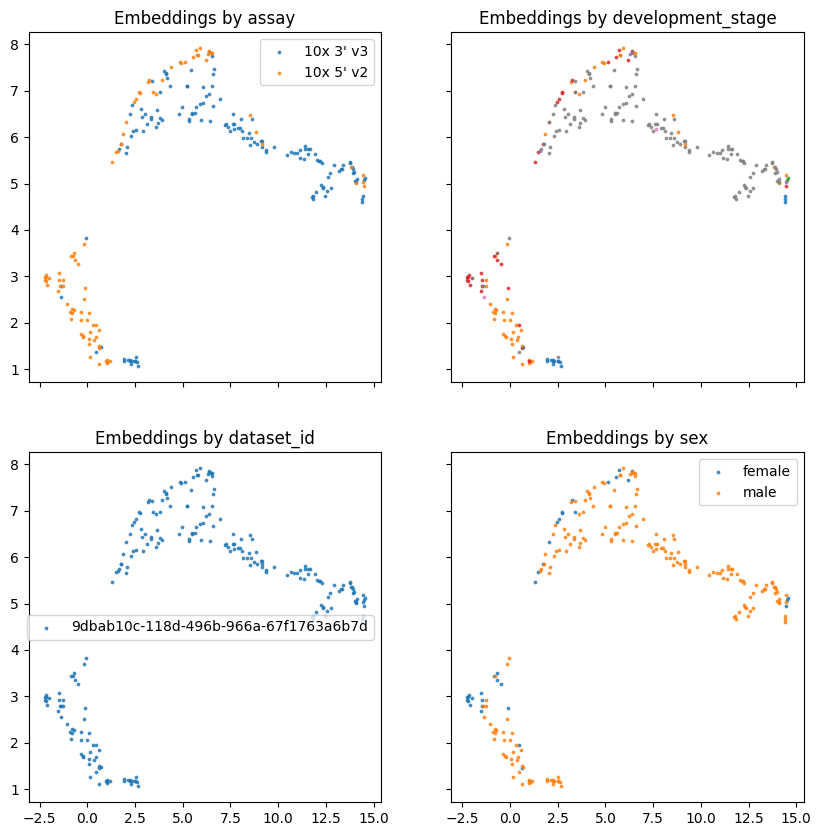

In [18]:
from matplotlib import pyplot as plt


results = adata_test.obs.copy()
results["x"] = embedding[:, 0]
results["y"] = embedding[:, 1]

covariates = ["assay", "development_stage", "dataset_id", "sex"]
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 10))

for ax, covar in zip(axes.flat, covariates):
    for cov, cov_df in results.groupby(covar):
        ax.scatter(
            cov_df.x,
            cov_df.y,
            s=3,
            alpha=0.75,
            label=cov,
        )
    if len(results[covar].unique()) < 8:
        ax.legend()
    ax.set_title(f"Embeddings by {covar}")

In [19]:
adata_test.obs.columns

Index(['soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id',
       'cell_type', 'cell_type_ontology_term_id', 'development_stage',
       'development_stage_ontology_term_id', 'disease',
       'disease_ontology_term_id', 'donor_id', 'is_primary_data',
       'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id',
       'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue',
       'tissue_ontology_term_id', 'tissue_general',
       'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz',
       'raw_variance_nnz', 'n_measured_vars'],
      dtype='object')